Simulation type: S1
Lenght of the path: 27
Shortest path from 10050834266 to 2091252220: 10050834266 -> 348035828 -> 348035830 -> 348035824 -> 261611529 -> 261603716 -> 115805260 -> 115805262 -> 261601759 -> 453506375 -> 2848397722 -> 454593448 -> 261601602 -> 454621132 -> 2848898246 -> 453511664 -> 454621142 -> 453511666 -> 454621285 -> 454621280 -> 454593447 -> 6173124174 -> 454593446 -> 458852639 -> 458852642 -> 458852676 -> 2091252220
Travel time : 0.0h 4.0min and 15.497073853955783s


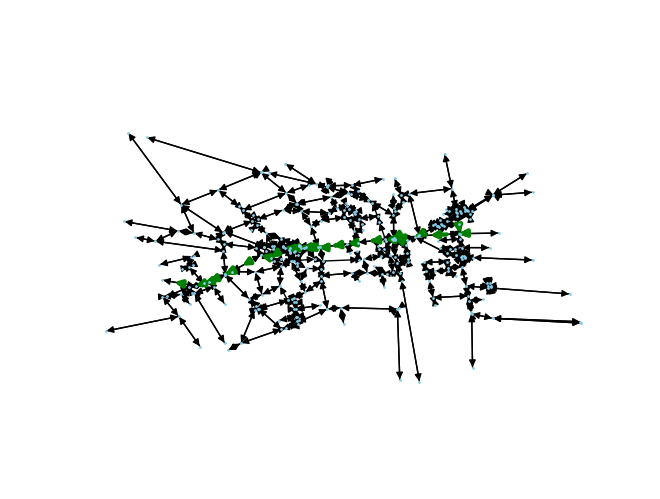

Simulation type: S2
Lenght of the path: 29
Shortest path from 10050834266 to 2091252220: 10050834266 -> 348035828 -> 348035830 -> 348035824 -> 261611529 -> 261603716 -> 115805260 -> 115805262 -> 261601759 -> 453506375 -> 2848397722 -> 454593448 -> 261601602 -> 454621132 -> 2848898246 -> 453511664 -> 454621142 -> 453511666 -> 454621285 -> 454621287 -> 454593439 -> 454593442 -> 454621312 -> 454621309 -> 454593446 -> 458852639 -> 458852642 -> 458852676 -> 2091252220
Travel time : 0.0h 3.0min and 47.801650990389135s


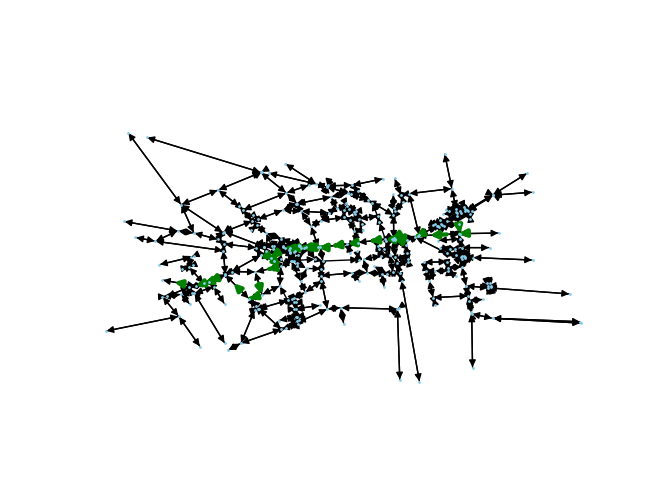

Simulation type: S3
Lenght of the path: 31
Shortest path from 10050834266 to 2091252220: 10050834266 -> 348035828 -> 348035830 -> 348035824 -> 261611529 -> 261603716 -> 115805260 -> 115805262 -> 261601759 -> 453506375 -> 2848397722 -> 454593448 -> 261601602 -> 454621132 -> 2848898246 -> 453511664 -> 454621142 -> 454621139 -> 454621292 -> 837693119 -> 454593435 -> 454621298 -> 454593439 -> 454593442 -> 454621312 -> 454621309 -> 454593446 -> 458852639 -> 458852642 -> 458852676 -> 2091252220
Travel time : 0.0h 3.0min and 43.57806780061543s


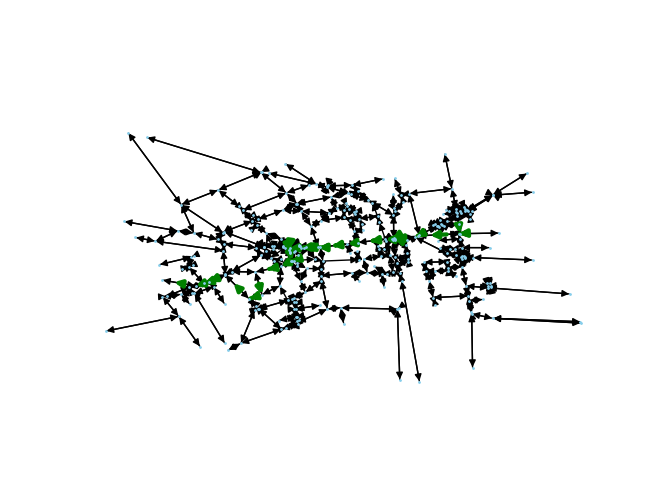

Simulation type: S4
Lenght of the path: 29
Shortest path from 10050834266 to 2091252220: 10050834266 -> 348035828 -> 348035830 -> 348035824 -> 261611529 -> 261603716 -> 115805260 -> 115805262 -> 261601759 -> 453506375 -> 2848397722 -> 454593448 -> 261601602 -> 454621132 -> 2848898246 -> 837701631 -> 2848898242 -> 837693119 -> 454593435 -> 454621298 -> 454593439 -> 454593442 -> 454621312 -> 454621309 -> 454593446 -> 458852639 -> 458852642 -> 458852676 -> 2091252220
Travel time : 0.0h 3.0min and 42.14386225041818s


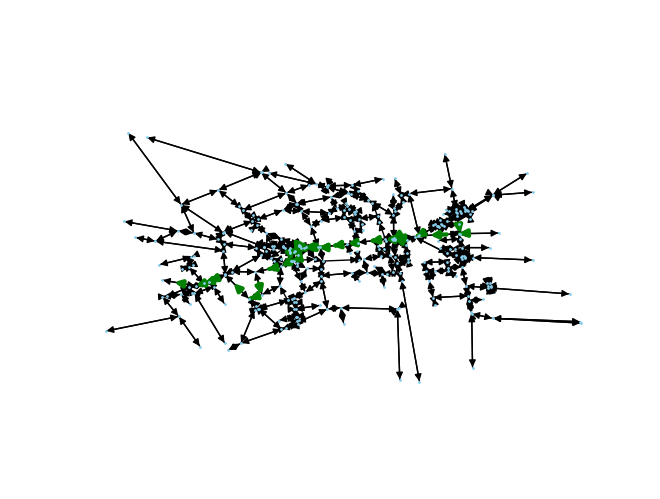

In [3]:
import csv
import networkx as nx
import matplotlib.pyplot as plt
import random
from math import radians, cos, sin, asin, sqrt
from itertools import combinations
import time
import numpy as np
import pandas as pd

nodes_file_path = '../Sources/map/map_bischoffsheim_node_list.csv'
edges_file_path = '../Sources/map/map_bischoffsheim_edge_list.csv'


def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in meters between two points 
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    r = r * 1000
    return c * r

def edges_within_distance_from_id(nodes_pos, origin_id, distance, perturbed_edges):
    """
    Returns a list of edges within a given distance from an origin point identified by its ID,
    and that are contained within the perturbed_edges list.

    Parameters:
    - nodes_pos: Dictionary of node positions with node IDs as keys and (longitude, latitude) as values
    - origin_id: ID of the origin point
    - distance: Distance range in kilometers
    - perturbed_edges: List of tuples representing perturbed edges, where each tuple is (node_id1, node_id2)
    """
    if origin_id not in nodes_pos:
        raise ValueError("Origin ID not found in nodes positions.")
    origin_lon, origin_lat = nodes_pos[origin_id]
    within_distance = []
    for node_id, (lon, lat) in nodes_pos.items():
        if haversine(origin_lon, origin_lat, lon, lat) <= distance:
            within_distance.append(node_id)
    filtered_edges = []
    for edge in perturbed_edges:
        u, v = edge
        if u in within_distance and v in within_distance:    
            filtered_edges.append(edge)
    return filtered_edges

def getNodes(nodes_file_path):
    nodes_list = []
    nodes_pos = {}  # Dictionary for node positions
    with open(nodes_file_path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        counter = 0
        for row in csv_reader:
            if counter == 0:
                counter += 1   
            else:
                node_id = str(row[0])
                longitude = float(row[1])
                latitude = float(row[2])
                nodes_list.append(node_id)
                nodes_pos[node_id] = (longitude, latitude)
    return nodes_list, nodes_pos

def setEdges(city, edges_file_path):
    with open(edges_file_path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        counter = 0
        for row in csv_reader:
            if counter == 0:
                counter += 1   
            else:
                if row[2] == 'default':
                    row[2] = 50
                city.add_edge(str(row[0]), str(row[1]), weight=float(row[4])/1000/float(row[2])*3600)
    return city   

def add_perturbations(graph, perturbed_edges, random = False):
    """Adds a consistent perturbation to the specified edges in the graph in one direction only.
    
    Parameters:
    - graph: A directed graph object from NetworkX.
    - perturbed_edges: A list of tuples representing the edges to be perturbed.
    """
    for edge in perturbed_edges:
        u, v = edge  # Unpack the edge tuple into start (u) and end (v) nodes
        if graph.has_edge(u, v):  # Check if the edge exists in the specified direction
            if random:
                graph[u][v]['weight'] += random.randint(1, 5) * weight_of_perturbation
            else:
                graph[u][v]['weight'] += weight_of_perturbation
        else:
            print(f"Edge {u} -> {v} not found in graph.")

    return perturbed_edges

def display_graph(graph, nodes_pos, shortest_path, perturbed_edges):
    # Draw the entire graph without labels
    nx.draw(graph, nodes_pos, with_labels=False, node_color='skyblue', node_size=1, edge_color='black', linewidths=1, font_size=15)
    # Draw the shortest path in green
    path_edges = [(shortest_path[n], shortest_path[n+1]) for n in range(len(shortest_path) - 1)]
    nx.draw_networkx_edges(graph, nodes_pos, edgelist=path_edges, edge_color='green', width=3)
    # Draw the perturbed edges in red
    # nx.draw_networkx_edges(graph, nodes_pos, edgelist=perturbed_edges, edge_color='red', width=1)
    plt.show()

def display_info(adjusted_path, total_seconds, source, target, type):
    hours = total_seconds // 3600
    minutes = (total_seconds % 3600) // 60
    seconds = total_seconds % 60
    travel_time = f"{hours}h {minutes}min and {seconds}s"
    print("==================")
    print("Simulation type: " + type)
    print(f"Lenght of the path: {len(adjusted_path)}")
    print(f"Shortest path from {source} to {target}: {' -> '.join(adjusted_path)}")
    print(f"Travel time : {travel_time}")
    print("==================")

def s1(graph, source, target, perturbed_edges, random, display=True):
    """Simulation where perturbations are applied to the weights of the edges of the initial shortest path."""
    # Create a copy of the graph
    G_copy = graph.copy()
    # Find the shortest path before perturbations
    adjusted_path = nx.dijkstra_path(G_copy, source=source, target=target, weight='weight')
    # Apply perturbations
    add_perturbations(G_copy, perturbed_edges, random)
    # Recalculate the length of the initial path with perturbed weights
    perturbed_length = sum(G_copy[u][v]['weight'] for u, v in zip(adjusted_path, adjusted_path[1:]))
    # Convert to total minutes
    total_seconds = perturbed_length
    # Extract hours, minutes, and seconds
    if display:
        display_info(adjusted_path, total_seconds, source, target, "S1")
    return adjusted_path, total_seconds

def s2(graph, source, target, perturbed_edges, random, display=True):
    # Create a copy of the graph
    perturbed_edges_copy = perturbed_edges.copy()
    G_copy = graph.copy()
    G_copy2 = graph.copy()
    # Apply perturbations before finding the path
    add_perturbations(G_copy2, perturbed_edges_copy, random)
    # Find the shortest path
    path = nx.dijkstra_path(G_copy, source=source, target=target, weight='weight')
    # Iteratively adjust the path if a perturbed edge is encountered
    adjusted_path = []
    current_node = source
    while current_node != target:
        next_node = path[path.index(current_node) + 1]
        adjusted_path.append(current_node)
        # Check if any edge from the current node is perturbed
        perturbed = False
        for next_node in G_copy.neighbors(current_node):
            if (current_node, next_node) in perturbed_edges_copy:
                perturbed = True
                # Add the perturbation on the copy
                G_copy[current_node][next_node]['weight'] = G_copy2[current_node][next_node]['weight']
        if(perturbed):
            # Restart djikstra to obtain the new calculated path
            path = nx.dijkstra_path(G_copy, source=current_node, target=target, weight='weight')
        current_node = path[path.index(current_node) + 1]
    adjusted_path.append(current_node)
    adjusted_length = sum(G_copy2[u][v]['weight'] for u, v in zip(adjusted_path[:-1], adjusted_path[1:]))
    # Convert to total minutes
    total_seconds = adjusted_length
    # Extract hours, minutes, and seconds
    if display:
        display_info(adjusted_path, total_seconds, source, target, "S2")
    return adjusted_path, total_seconds

def s3(graph, nodes_pos, distance, source, target, perturbed_edges, random, display=True):
    # Create a copy of the graph
    G_copy = graph.copy()
    G_copy2 = graph.copy()
    perturbed_edges_copy = perturbed_edges.copy()
    # Apply perturbations before finding the path
    add_perturbations(G_copy2, perturbed_edges_copy, random)
    # Iteratively adjust the path if a perturbed edge is encountered
    adjusted_path = [source]
    current_node = source
    path = nx.dijkstra_path(G_copy, source=current_node, target=target, weight='weight')
    path_state = 0
    while current_node != target:
        # Checking for perturbed edges directly on the path
        modified = False
        for node in G_copy.neighbors(current_node):
            if (current_node, node) in perturbed_edges_copy:
                G_copy[current_node][node]['weight'] = G_copy2[current_node][node]['weight']
                modified = True
        # Checking for perturbed edges near the current node
        nearby_perturbed_edges = edges_within_distance_from_id(nodes_pos, current_node, distance, perturbed_edges_copy)
        for edge in nearby_perturbed_edges:
            u, v = edge
            G_copy[u][v]['weight'] = G_copy2[u][v]['weight']
            modified = True

        if modified:
            path = nx.dijkstra_path(G_copy, source=current_node, target=target, weight='weight')
            path_state = 1
        else:
            path_state += 1
            
        adjusted_path.append(path[path_state])
        current_node = path[path_state]
    # Calculation and display of travel time
    adjusted_length = sum(G_copy2[u][v]['weight'] for u, v in zip(adjusted_path[:-1], adjusted_path[1:]))
    # Convert to total minutes
    total_seconds = adjusted_length
    # Extract hours, minutes, and seconds
    if display:
        display_info(adjusted_path, total_seconds, source, target, "S3")
    return adjusted_path, total_seconds

def s4(graph, source, target, perturbed_edges, random, display=True):
    G_copy = graph.copy()
    """Simulation where perturbations are applied before finding the shortest path."""
    # Apply perturbations before finding the path
    add_perturbations(G_copy, perturbed_edges, random)
    # Find the shortest path
    adjusted_path = nx.dijkstra_path(G_copy, source=source, target=target, weight='weight')
    # Display path info with perturbations considered
    perturbed_length = sum(G_copy[u][v]['weight'] for u, v in zip(adjusted_path, adjusted_path[1:]))
    # Convert to total minutes
    total_seconds = perturbed_length
    # Extract hours, minutes, and seconds
    if display:
        display_info(adjusted_path, total_seconds, source, target, "S4")
    return adjusted_path, total_seconds

if __name__ == '__main__':
    
    nodes, nodes_pos = getNodes(nodes_file_path)
    city = nx.DiGraph()
    city.add_nodes_from(nodes)
    city = setEdges(city, edges_file_path)
    all_edges = city.edges(data=False)
    edges_list = list(all_edges)
    edges_number = len(edges_list)
    travel_time_s2, travel_time_s3, travel_time_s4 = 0, 1, 2
    path_s1, path_s2, path_s3, path_s4 = [], [], [], []
    
    random_perturbation = False
    display = False
    pourcentage = 10
    weight_of_perturbation = 60
    
    perturbed_edges = random.sample(edges_list, k = int(edges_number * pourcentage / 100))
    source = random.choice(nodes)
    target = random.choice(nodes)
    
    while travel_time_s2 < travel_time_s3 or travel_time_s3 < travel_time_s4 or travel_time_s1 < travel_time_s3 or len(path_s1) < 10:
        path_s1, travel_time_s1 = s1(city, source, target, perturbed_edges, random_perturbation, display)
        path_s2, travel_time_s2 = s2(city, source, target, perturbed_edges, random_perturbation, display)
        path_s3, travel_time_s3 = s3(city, nodes_pos, 200, source, target, perturbed_edges, random_perturbation, display)
        path_s4, travel_time_s4 = s4(city, source, target, perturbed_edges, random_perturbation, display)
    
    display_info(path_s1, travel_time_s1, source, target, "S1")
    display_graph(city, nodes_pos, path_s1, perturbed_edges)
    
    display_info(path_s2, travel_time_s2, source, target, "S2")
    display_graph(city, nodes_pos, path_s2, perturbed_edges)
    
    display_info(path_s3, travel_time_s3, source, target, "S3")
    display_graph(city, nodes_pos, path_s3, perturbed_edges)
    
    display_info(path_s4, travel_time_s4, source, target, "S4")
    display_graph(city, nodes_pos, path_s4, perturbed_edges)                     